In [1]:
from obstacle_tower_env import ObstacleTowerEnv
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:

# Realtime mode determines whether the environment window will render the scene,
# as well as whether the environment will run at realtime speed. Set this to `True`
# to visual the agent behavior as you would in player mode.

env = ObstacleTowerEnv('./obstacletower', retro=False, realtime_mode=False)

INFO:mlagents_envs:
'ObstacleTower-v1.2' started successfully!
Unity Academy name: ObstacleTower-v1.2
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		dense-reward -> 1.0
		floor-number -> 0.0
		tower-seed -> -1.0
Unity brain name: LearningBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 7
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 2, 3]
        Vector Action descriptions: Movement Forward/Back, Camera, Jump, Movement Left/Right
INFO:gym_unity:1 agents within environment.


TypeError: 'int' object is not subscriptable

In [3]:
# The environment provided has a MultiDiscrete action space, where the 4 dimensions are:

# 0. Movement (No-Op/Forward/Back)
# 1. Camera Rotation (No-Op/Counter-Clockwise/Clockwise)
# 2. Jump (No-Op/Jump)
# 3. Movement (No-Op/Right/Left)

env.action_space

NameError: name 'env' is not defined

In [29]:
# The observation space provided includes a 168x168 image (the camera from the simulation)
# as well as the number of keys held by the agent (0-5) and the amount of time remaining.

env.observation_space

Tuple(Box(168, 168, 3), Discrete(5), Box(1,))

# Interacting with the environment

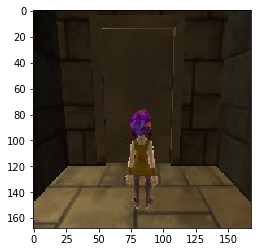

In [30]:
obs = env.reset()
plt.imshow(obs[0])

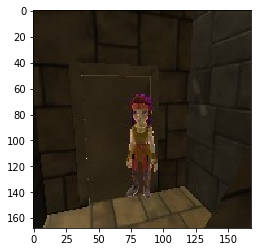

In [31]:
obs, reward, done, info = env.step(env.action_space.sample())
plt.imshow(obs[0])

# Setting environment parameters 
We can also set the random seed used to generate the environment, as well as choose a starting floor 

In [32]:
# Seeds can be chosen from range of 0-100.
env.seed(5)

In [33]:
# Floors can be chosen from range of 0-24.
env.floor(1)

INFO:mlagents_envs:Academy reset with parameters: floor-number -> 1, tower-seed -> 5


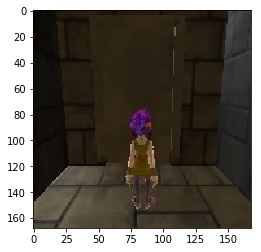

In [34]:
# These parameters won't take place until the next reset.
obs = env.reset()
plt.imshow(obs[0])

# Closing the environment 

In [45]:
env.close()

# START HERE FOR ACTOR CRITIC APPROACH!


# Launching the environment (retro mode) 
We also provide a retro mode which uses observation and action spaces similar to those found in the Arcade Learning Environment (ALE).

In [1]:
from obstacle_tower_env import ObstacleTowerEnv
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
env = ObstacleTowerEnv('./obstacletower', retro=True)

INFO:mlagents_envs:
'ObstacleTower-v1.2' started successfully!
Unity Academy name: ObstacleTower-v1.2
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		dense-reward -> 1.0
		floor-number -> 0.0
		tower-seed -> -1.0
Unity brain name: LearningBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 7
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 2, 3]
        Vector Action descriptions: Movement Forward/Back, Camera, Jump, Movement Left/Right
INFO:gym_unity:1 agents within environment.


In [3]:
# In retro mode, the observation is an 84x84 image with the time remaining and key count visually embedded.
env.observation_space

Box(84, 84, 3)

# Interacting with the environment (retro mode) 

In [4]:
obs = env.reset()
print(obs.shape)

(84, 84, 3)


(84, 84)


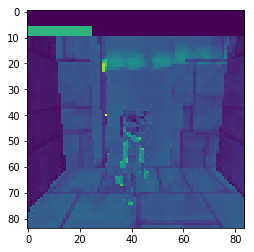

In [3]:
import cv2

obs, reward, done, info = env.step(env.action_space.sample())
if len(obs.shape) > 2:
    obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)

plt.imshow(obs)
print(obs.shape)

# Closing the environment 

In [21]:
env.close()

# Actor-Critic Reinforcement Learning



In [4]:
import numpy as np
import tensorflow as tf

if not tf.test.is_gpu_available():
    print("No GPU available or connected")

OUTPUT_GRAPH = True 
MAX_EPISODE = 3000
DISPLAY_REWARD_THRESHOLD = 200  # renders environment if total episode reward is greater then this threshold
MAX_EP_STEPS = 1000 # maximum time step in one episode 
RENDER = False # rendering wastes time 
GAMMA = 0.9 # reward discount in TD error 
LR_A = 0.001 # actor learning rate 
LR_C = 0.01 # critic learning rate 

In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4541375611789919400, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6664374190
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7708204260030290562
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [5]:
env.seed(1) # for reproducability

In [6]:
N_F = env.observation_space.shape[0] # number features 84
N_A = env.action_space.n # number actions 54 

In [14]:
class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "act")
        self.td_error = tf.placeholder(tf.float32, None, "td_error")  # TD_error

        self.s = self.s[:,:,:,np.newaxis] # artifact to create 4dim space (1st dim = batchsize)
        #print("SELF.S SHAPE: " + str(self.s.shape))
        with tf.variable_scope('Actor'):
            self.input_layer = tf.layers.conv2d(
                inputs=self.s,
                filters=2*2,
                kernel_size=[2, 2],
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='input_layer'
            )

            self.scnd_conv = tf.layers.conv2d(
                inputs=self.input_layer,
                filters=2*2,
                kernel_size=[2, 2],
                activation=tf.nn.relu,   # get action probabilities
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='scnd_conv'
            )
            
            self.flatten = tf.layers.flatten(
                inputs=self.scnd_conv,
                name='flatten'
            )
            
            self.dense = tf.layers.dense(
                inputs=self.flatten,
                units=200, 
                activation=tf.nn.relu,
                name='1st_dense'
            )
            
            self.acts_prob = tf.layers.dense(
                inputs=self.dense,
                units=54, 
                activation=tf.nn.softmax,
                name='acts_prob'
            )
            
            

        with tf.variable_scope('exp_v'):
            log_prob = tf.log(self.acts_prob[0, self.a])
            self.exp_v = tf.reduce_mean(log_prob * self.td_error)  # advantage (TD_error) guided loss

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)  # minimize(-exp_v) = maximize(exp_v)

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    # choose action based on previous state s 
    def choose_action(self, s):
        s = s[np.newaxis, :]
        #print(" S :" + str(s.shape)) # shape: (1, 84, 84, 1)
        # wants s to be of dimsize self.s (1, 84, 84, 1)
        probs = self.sess.run(self.acts_prob, {self.s: s})   # get probabilities for all actions
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int

    

In [15]:
class Critic(object):
    def __init__(self, sess, n_features, lr=0.01):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features, n_features], "state")
        self.v_ = tf.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.placeholder(tf.float32, None, 'r')

        #self.s = np.expand_dims(self.s, axis=3)
        self.s = self.s[:,:,:,np.newaxis] # artifact to create 4dim space (1st dim = batchsize)
        with tf.variable_scope('Critic'):
            self.input_layer = tf.layers.conv2d(
                inputs=self.s,
                filters=2*2,
                kernel_size=[2, 2],
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='input_layer'
            )

            self.scnd_conv = tf.layers.conv2d(
                inputs=self.input_layer,
                filters=2*2,
                kernel_size=[2, 2],
                activation=tf.nn.relu,   # get action probabilities
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='scnd_conv'
            )
            
            self.flatten = tf.layers.flatten(
                inputs=self.scnd_conv,
                name='flatten'
            )
            
            self.dense = tf.layers.dense(
                inputs=self.flatten,
                units=200, 
                activation=tf.nn.relu,
                name='1st_dense'
            )
            
            self.v = tf.layers.dense(
                inputs=self.dense,
                units=1, 
                activation=tf.nn.softmax,
                name='V'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.r + GAMMA * self.v_ - self.v
            self.loss = tf.square(self.td_error)    # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error

In [16]:
tf.reset_default_graph()
#sess = tf.Session()
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
writer = tf.summary.FileWriter('./graphs', sess.graph)

actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F, lr=LR_C)     # we need a good teacher, so the teacher should learn faster than the actor

sess.run(tf.global_variables_initializer())

if OUTPUT_GRAPH:
    tf.summary.FileWriter("logs/", sess.graph)

ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[node train_1/beta2_power/initial_value (defined at <ipython-input-15-aac44e34fcc5>:55) ]]

Caused by op 'train_1/beta2_power/initial_value', defined at:
  File "c:\users\marie\appdata\local\programs\python\python36\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\marie\appdata\local\programs\python\python36\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\users\marie\appdata\local\programs\python\python36\Lib\asyncio\base_events.py", line 427, in run_forever
    self._run_once()
  File "c:\users\marie\appdata\local\programs\python\python36\Lib\asyncio\base_events.py", line 1440, in _run_once
    handle._run()
  File "c:\users\marie\appdata\local\programs\python\python36\Lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-502bbc2ab254>", line 9, in <module>
    critic = Critic(sess, n_features=N_F, lr=LR_C)     # we need a good teacher, so the teacher should learn faster than the actor
  File "<ipython-input-15-aac44e34fcc5>", line 55, in __init__
    self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\training\optimizer.py", line 413, in minimize
    name=name)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\training\optimizer.py", line 595, in apply_gradients
    self._create_slots(var_list)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\training\adam.py", line 131, in _create_slots
    colocate_with=first_var)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\training\optimizer.py", line 828, in _create_non_slot_variable
    colocate_with))
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 1395, in __init__
    constraint=constraint)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\ops\variables.py", line 1515, in _init_from_args
    initial_value, name="initial_value", dtype=dtype)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\ops.py", line 1039, in convert_to_tensor
    return convert_to_tensor_v2(value, dtype, preferred_dtype, name)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\ops.py", line 1097, in convert_to_tensor_v2
    as_ref=False)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\ops.py", line 1175, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\constant_op.py", line 304, in _constant_tensor_conversion_function
    return constant(v, dtype=dtype, name=name)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\constant_op.py", line 245, in constant
    allow_broadcast=True)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\constant_op.py", line 289, in _constant_impl
    name=name).outputs[0]
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "c:\users\marie\documents\isy-prj-obstacle-tower-env\obstacletower\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [] and type float
	 [[node train_1/beta2_power/initial_value (defined at <ipython-input-15-aac44e34fcc5>:55) ]]


In [ ]:
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    # change RGB img to Gray 
    if len(s.shape) > 2:
        s = cv2.cvtColor(s, cv2.COLOR_RGB2GRAY)
        s = np.expand_dims(s, axis=3) # artifact to create 4dim space (1st dim = batchsize)
    # show state 
    plt.imshow(obs)
    
    t = 0
    track_r = []
    track_a = []
    track_s = []
    while True:
        if RENDER: env.render()

        a = actor.choose_action(s) # state of dim (1, 84, 84) fed to actor to choose the next action based on the current state

        s_, r, done, info = env.step(a)
        if len(s_.shape) > 2:
            s_ = cv2.cvtColor(s_, cv2.COLOR_RGB2GRAY)
            s_ = np.expand_dims(s_, axis=3) # artifact to create 4dim space (1st dim = batchsize)
            

        if done: r = -20

        track_r.append(r)
        track_a.append(a)
        track_s.append(s)

        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)     # true_gradient = grad[logPi(s,a) * td_error]
        print("Td_Error: " + str(td_error) + "  Reward: " + str(r) + "  Action: " + str(a))
        s = s_
        t += 1

        if done or t >= MAX_EP_STEPS:
            ep_rs_sum = sum(track_r)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))
            break
